In [1]:
# -*- coding: utf-8 -*-

from matplotlib import pyplot as plt
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader
import torch
import os
from torch.optim import *
from torch import nn
from torch.nn import functional as F
from scipy import ndimage
import pandas as pd
from copy import deepcopy
import random
from sklearn.metrics import f1_score
import json
from sklearn.metrics import classification_report
import torchvision.models as models
import pickle
from sklearn.metrics import precision_recall_curve

random.seed(7)
torch.cuda.manual_seed(7)
torch.manual_seed(7)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(7)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


In [25]:
DATA_ROOT = '/beegfs/bva212/openmic-2018'
OPENMIC = np.load(os.path.join(DATA_ROOT, 'openmic-2018.npz'))
X, Y_true, Y_mask, sample_key = OPENMIC['X'], OPENMIC['Y_true'], OPENMIC['Y_mask'], OPENMIC['sample_key']

In [3]:
train_samples = pd.read_csv(os.path.join(DATA_ROOT,'partitions/split01_train.csv'), names =['id']).to_numpy().squeeze()
test_samples = pd.read_csv(os.path.join(DATA_ROOT,'partitions/split01_test.csv'), names =['id']).to_numpy().squeeze()

In [4]:
test_idx = np.isin(sample_key, test_samples)

In [5]:
with open(os.path.join(DATA_ROOT, 'class-map.json'), 'r') as f:
    class_map = json.load(f)

In [26]:
class ArrowOfTime(Dataset):

    def __init__(self, root_dir, files, weights, label):
        self.weights = weights
        self.device = device
        self.root_dir = root_dir
        self.files = files
        self.label = label

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        logscalogram = (np.load(self.root_dir + self.files[idx]+'_cqt.npy') - -24.3633)/14.2659
        weight = self.weights[idx]
        label = (self.label[idx] > 0.5).astype(int)
        return {'logscalogram': logscalogram[np.newaxis, :], 'label': label[np.newaxis, :], 'weight': weight[np.newaxis, :]}

filenames = []
root_dir = '/beegfs/bva212/openmic-2018/cqt_full/'

BATCH_SIZE = 32

def my_collate(batch):
    data = np.stack([item['logscalogram'] for item in batch])
    target = np.concatenate([item['label'] for item in batch],axis=0)
    weight = np.concatenate([item['weight'] for item in batch],axis=0)
    weight_sum = weight.sum(0)
    weight_sum = np.repeat(weight_sum[np.newaxis, :], len(batch), 0)
    weight_sum[weight_sum==0]=1
    weight = weight/weight_sum
    return [torch.from_numpy(data).float(), torch.from_numpy(target).float(), torch.from_numpy(weight).float()]


In [27]:
class snet2_jigsaw(nn.Module):

    def __init__(self, output_classes = 20):
        '''
        Create the 5 Conv Layer Sound Net network architecture as per the paper - https://arxiv.org/pdf/1610.09001.pdf
        '''
        super(snet2_jigsaw, self).__init__()

        self.conv_layers = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels= 16, kernel_size = 5, stride = 2, padding = 5), 
                                nn.BatchNorm2d(num_features = 16), 
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 2, padding = 5),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, padding = 5),
                                nn.BatchNorm2d(64),
                                nn.ReLU(inplace = True),
                                nn.AvgPool2d(kernel_size = 3),

                                nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, padding = 4),
                                nn.BatchNorm2d(128),
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 4, padding = 4),
                                nn.BatchNorm2d(256),
                                nn.ReLU(inplace = True),
                                nn.AvgPool2d(kernel_size = 3),

                                nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 2, padding = 3),
                                nn.BatchNorm2d(512),
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 2, padding = 3),
                                nn.BatchNorm2d(1024),
                                nn.ReLU(inplace = True),
                                nn.AdaptiveAvgPool2d(output_size = 1)
                                )
        self.mlp_layer = nn.Linear(1024, output_classes)
              
    def forward(self, input):
        out = self.conv_layers(input)
        out = self.mlp_layer(out.view(out.shape[0], -1))
        return out
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
        
# Function for testing the model
def test_model(loader, model):
    correct = 0
    total_loss = 0
    total = 0
    total_num = 0
    model.eval()
    with torch.no_grad():
        wgt, true_tgt, preds = torch.zeros((1, len(class_map))).to(device), torch.zeros((1, len(class_map))).to(device), \
                                            torch.zeros((1, len(class_map))).to(device)
        for spectrogram, target, weight in loader:
            spectrogram_batch, target_batch, weight_batch = spectrogram.to(device), target.to(device), weight.to(device)
            outputs = model(spectrogram_batch)
#             print(label_batch.shape)
            tgt = (target_batch>0.5).float()
            predicted = (torch.sigmoid(outputs.data)>0.5).float()
            loss = F.binary_cross_entropy_with_logits(outputs, target_batch,
                                                  weight = weight_batch,
                                                  reduction='sum')
            total_loss += loss.item()
            total += weight_batch.shape[0]

            correct += ((weight_batch != 0).float()*(predicted.eq(tgt.view_as(predicted)).float())).sum().item()
            total_num += (weight_batch != 0).sum().item()
            
            wgt = torch.cat((wgt, weight_batch), dim=0)
            true_tgt = torch.cat((true_tgt, tgt), dim=0)
            preds = torch.cat((preds, predicted), dim=0)
    
#         print(wgt.shape, y_true.shape, y_preds.shape)
        class_wise_results = {}
        for instrument, label in class_map.items():
#             print(instrument, label)
            y_true = true_tgt[(wgt[:,label] != 0),label].cpu()
            y_preds = preds[(wgt[:,label] != 0),label].cpu()
#             print(y_preds.shape) 
            class_wise_results[instrument] = classification_report(y_true, y_preds, output_dict = True)    
        
    return (100 * correct / total_num), (total_loss/total), class_wise_results

In [8]:
sizes = [10, 50, 250, 500, 'Full']

Test_dataset = ArrowOfTime(root_dir, sample_key[test_idx], Y_mask[test_idx], Y_true[test_idx])
Test_loader = torch.utils.data.DataLoader(dataset = Test_dataset, 
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                        collate_fn = my_collate)

results_dict = {}
wt = pickle.load(open('/scratch/rc3620/Capstone/Size_Exp_Flip_Wt_Results.pkl','rb'))

for i in range(len(sizes)):
    model = snet2_jigsaw(20)
    model.load_state_dict(wt[sizes[i]]['best_model_state_dict'])
    model.to(device)
    results = test_model(Test_loader, model)
    results_dict[sizes[i]] = results
pickle.dump(results_dict, open('Test_Results_Flip_Wt_Size_Exp.pkl','wb'))

/home/rc3620/miniconda3/envs/localenv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [9]:
results_dict = {}
wt = pickle.load(open('/scratch/rc3620/Capstone/Size_Exp_Random_Wt_NoLinear_Results.pkl','rb'))

for i in range(len(sizes)):
    model = snet2_jigsaw(20)
    model.load_state_dict(wt[sizes[i]]['best_model_state_dict'])
    model.to(device)
    results = test_model(Test_loader, model)
    results_dict[sizes[i]] = results
pickle.dump(results_dict, open('Test_Results_Random_Wt_NoLinear_Size_Exp.pkl','wb'))

In [10]:
results_dict = {}
wt = pickle.load(open('/scratch/rc3620/Capstone/Size_Exp_Jigsaw_1s_Wt_NoLin_Results.pkl','rb'))

for i in range(len(sizes)):
    model = snet2_jigsaw(20)
    model.load_state_dict(wt[sizes[i]]['best_model_state_dict'])
    model.to(device)
    results = test_model(Test_loader, model)
    results_dict[sizes[i]] = results
pickle.dump(results_dict, open('Test_Results_Jigsaw_1s_Wt_NoLin_Size_Exp.pkl','wb'))

In [11]:
results_dict = {}
wt = pickle.load(open('/scratch/rc3620/Capstone/Size_Exp_Jigsaw_Wt_NoLin_Results.pkl','rb'))

for i in range(len(sizes)):
    model = snet2_jigsaw(20)
    model.load_state_dict(wt[sizes[i]]['best_model_state_dict'])
    model.to(device)
    results = test_model(Test_loader, model)
    results_dict[sizes[i]] = results
pickle.dump(results_dict, open('Test_Results_Jigsaw_Wt_NoLin_Size_Exp.pkl','wb'))

In [20]:
class snet2_jigsaw(nn.Module):

    def __init__(self, output_classes = 20):
        '''
        Create the 5 Conv Layer Sound Net network architecture as per the paper - https://arxiv.org/pdf/1610.09001.pdf
        '''
        super(snet2_jigsaw, self).__init__()

        self.conv_layers = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels= 16, kernel_size = 5, stride = 2, padding = 5), 
                                nn.BatchNorm2d(num_features = 16), 
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 2, padding = 5),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, padding = 5),
                                nn.BatchNorm2d(64),
                                nn.ReLU(inplace = True),
                                nn.AvgPool2d(kernel_size = 3),

                                nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, padding = 4),
                                nn.BatchNorm2d(128),
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 4, padding = 4),
                                nn.BatchNorm2d(256),
                                nn.ReLU(inplace = True),
                                nn.AvgPool2d(kernel_size = 3),

                                nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 2, padding = 3),
                                nn.BatchNorm2d(512),
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 2, padding = 3),
                                nn.BatchNorm2d(1024),
                                nn.ReLU(inplace = True),
                                nn.AdaptiveAvgPool2d(output_size = 1)
                                )
        self.concat_mlp_layer = nn.Sequential(nn.Linear(3072, 2048),
                                              nn.BatchNorm1d(num_features = 2048), 
                                              nn.ReLU(inplace = True),
                                              
                                              nn.Linear(2048, 1024),
                                              nn.BatchNorm1d(num_features = 1024), 
                                              nn.ReLU(inplace = True),
                                              
                                              nn.Linear(1024, 256),
                                              nn.BatchNorm1d(num_features = 256), 
                                              nn.ReLU(inplace = True),
                                             )
        self.mlp_layer = nn.Linear(256, output_classes)
              
    def forward(self, input):
        conv_strips = []
        n_strips = input.shape[1]
        for strip in range(n_strips):
            conv_strip = input[:,strip]
            conv_strip = conv_strip.unsqueeze(1)
            conv_strips.append(self.conv_layers(conv_strip))

        concat_out=torch.cat(conv_strips,1)
        out = self.concat_mlp_layer(concat_out.view(concat_out.shape[0], -1))
        output = self.mlp_layer(out.view(out.shape[0], -1))
        return output
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
        
class ArrowOfTime(Dataset):

    def __init__(self, root_dir, files, weights, label):
        self.weights = weights
        self.device = device
        self.root_dir = root_dir
        self.files = files
        self.label = label

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        logscalogram = (np.load(self.root_dir + self.files[idx]+'_cqt.npy') - -24.3633)/14.2659
        len_cqt = logscalogram.shape[1]
        rem = len_cqt % 3
        logscalograms = np.split(logscalogram[:, :-rem], 3, axis = 1)
        logscalograms = np.stack(logscalograms)

        weight = self.weights[idx]
        label = (self.label[idx] >0.5).astype(int)
        return {'logscalogram': logscalograms, 'label': label[np.newaxis, :], 'weight': weight[np.newaxis, :]}

In [13]:
Test_dataset = ArrowOfTime(root_dir, sample_key[test_idx], Y_mask[test_idx], Y_true[test_idx])
Test_loader = torch.utils.data.DataLoader(dataset = Test_dataset, 
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                        collate_fn = my_collate)


results_dict = {}
wt = pickle.load(open('/scratch/rc3620/Capstone/Size_Exp_Jigsaw_Wt_Results.pkl','rb'))

for i in range(len(sizes)):
    model = snet2_jigsaw(20)
    model.load_state_dict(wt[sizes[i]]['best_model_state_dict'])
    model.to(device)
    results = test_model(Test_loader, model)
    results_dict[sizes[i]] = results
pickle.dump(results_dict, open('Test_Results_Jigsaw_Wt_Lin_Size_Exp.pkl','wb'))

In [14]:
results_dict = {}
wt = pickle.load(open('/scratch/rc3620/Capstone/Size_Exp_Random_Wt_Linear_Results.pkl','rb'))

for i in range(len(sizes)):
    model = snet2_jigsaw(20)
    model.load_state_dict(wt[sizes[i]]['best_model_state_dict'])
    model.to(device)
    results = test_model(Test_loader, model)
    results_dict[sizes[i]] = results
pickle.dump(results_dict, open('Test_Results_Random_Wt_Lin_Size_Exp.pkl','wb'))

In [15]:
results_dict = {}
wt = pickle.load(open('/scratch/rc3620/Capstone/Size_Exp_resnet_Jigsaw_Wt_Results.pkl','rb'))

for i in range(len(sizes)):
    model = models.resnet18(num_classes=20)
    model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    model = model.to(device)
    model.load_state_dict(wt[sizes[i]]['best_model_state_dict'])
    model.to(device)
    results = test_model(Test_loader, model)
    results_dict[sizes[i]] = results
pickle.dump(results_dict, open('Test_Results_Resnet_Jigsaw_Wt_Size_Exp.pkl','wb'))

In [16]:
results_dict = {}
wt = pickle.load(open('/scratch/rc3620/Capstone/Size_Exp_Random_Wt_Resnet_Results.pkl','rb'))

for i in range(len(sizes)):
    model = models.resnet18(num_classes=20)
    model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    model = model.to(device)
    model.load_state_dict(wt[sizes[i]]['best_model_state_dict'])
    model.to(device)
    results = test_model(Test_loader, model)
    results_dict[sizes[i]] = results
pickle.dump(results_dict, open('Test_Results_Resnet_Random_Wt_Size_Exp.pkl','wb'))

In [17]:
results_dict = {}
wt = pickle.load(open('/scratch/rc3620/Capstone/Size_Exp_Jigsaw_Wt_1s_Results.pkl','rb'))

for i in range(len(sizes)):
    model = snet2_jigsaw(20)
    model.load_state_dict(wt[sizes[i]]['best_model_state_dict'])
    model.to(device)
    results = test_model(Test_loader, model)
    results_dict[sizes[i]] = results
pickle.dump(results_dict, open('Test_Results_Jigsaw_1s_Wt_Size_Exp.pkl','wb'))


In [2]:
rand_nolin = pickle.load(open('Test_Results_Random_Wt_NoLinear_Size_Exp.pkl','rb'))
jigsaw_nolin = pickle.load(open('Test_Results_Jigsaw_Wt_NoLin_Size_Exp.pkl','rb'))
flip_nolin = pickle.load(open('Test_Results_Flip_Wt_Size_Exp.pkl','rb'))
rand_resnet = pickle.load(open('Test_Results_Resnet_Random_Wt_Size_Exp.pkl','rb'))
jigsaw_resnet = pickle.load(open('Test_Results_Resnet_Jigsaw_Wt_Size_Exp.pkl','rb'))
rand_lin = pickle.load(open('Test_Results_Random_Wt_Lin_Size_Exp.pkl','rb'))
jigsaw_lin = pickle.load(open('Test_Results_Jigsaw_Wt_Lin_Size_Exp.pkl','rb'))
jigsaw_1s_nolin = pickle.load(open('Test_Results_Jigsaw_1s_Wt_NoLin_Size_Exp.pkl','rb'))
jigsaw_1s_lin = pickle.load(open('Test_Results_Jigsaw_1s_Wt_Size_Exp.pkl','rb'))

In [3]:
rand_nolin_acc = [val[0] for key, val in rand_nolin.items()]
jigsaw_nolin_acc = [val[0] for key, val in jigsaw_nolin.items()]
flip_nolin_acc = [val[0] for key, val in flip_nolin.items()]
rand_resnet_acc = [val[0] for key, val in rand_resnet.items()]
jigsaw_resnet_acc = [val[0] for key, val in jigsaw_resnet.items()]
rand_lin_acc = [val[0] for key, val in rand_lin.items()]
jigsaw_lin_acc = [val[0] for key, val in jigsaw_lin.items()]
jigsaw_1s_nolin_acc = [val[0] for key, val in jigsaw_1s_nolin.items()]
jigsaw_1s_lin_acc = [val[0] for key, val in jigsaw_1s_lin.items()]

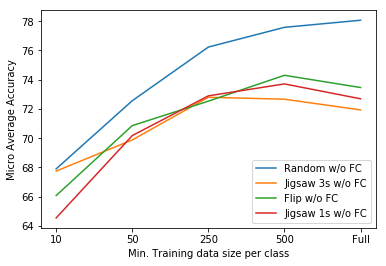

In [7]:
# plt.figure(figsize=(15,5))
sizes = [10, 50, 250, 500, 'Full']

plt.plot(sizes, rand_nolin_acc, label = 'Random w/o FC')
plt.plot(sizes, jigsaw_nolin_acc, label = 'Jigsaw 3s w/o FC')
plt.plot(sizes, flip_nolin_acc, label = 'Flip w/o FC')
plt.plot(sizes, jigsaw_1s_nolin_acc, label = 'Jigsaw 1s w/o FC')
plt.xlabel('Min. Training data size per class')
plt.ylabel('Micro Average Accuracy')
plt.legend()
plt.show()

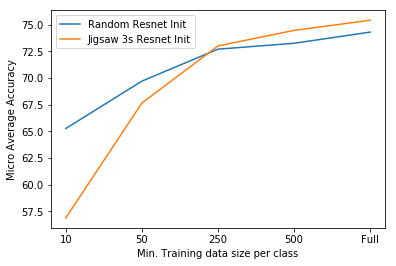

In [8]:
plt.plot(sizes, rand_resnet_acc, label = 'Random Resnet Init')
plt.plot(sizes, jigsaw_resnet_acc, label = 'Jigsaw 3s Resnet Init')
plt.xlabel('Min. Training data size per class')
plt.ylabel('Micro Average Accuracy')
plt.legend()
plt.show()

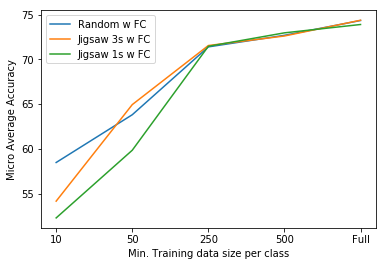

In [9]:
plt.plot(sizes, rand_lin_acc, label = 'Random w FC')
plt.plot(sizes, jigsaw_lin_acc, label = 'Jigsaw 3s w FC')
plt.plot(sizes, jigsaw_1s_lin_acc, label = 'Jigsaw 1s w FC')
plt.xlabel('Min. Training data size per class')
plt.ylabel('Micro Average Accuracy')
plt.legend()
plt.show()

In [28]:
def print_results(loader, model):
    correct = 0
    total_loss = 0
    total = 0
    total_num = 0
    model.eval()
    with torch.no_grad():
        wgt, true_tgt, preds, pred_probs = torch.zeros((1, len(class_map))).to(device), torch.zeros((1, len(class_map))).to(device), \
                                            torch.zeros((1, len(class_map))).to(device), torch.zeros((1, len(class_map))).to(device)
        for spectrogram, target, weight in loader:
            spectrogram_batch, target_batch, weight_batch = spectrogram.to(device), target.to(device), weight.to(device)
            outputs = model(spectrogram_batch)
#             print(label_batch.shape)
            tgt = (target_batch>0.5).float()
            predicted = (torch.sigmoid(outputs.data)>0.5).float()
            loss = F.binary_cross_entropy_with_logits(outputs, target_batch,
                                                  weight = weight_batch,
                                                  reduction='sum')
            total_loss += loss.item()
            total += weight_batch.shape[0]

            correct += ((weight_batch != 0).float()*(predicted.eq(tgt.view_as(predicted)).float())).sum().item()
            total_num += (weight_batch != 0).sum().item()
            
            wgt = torch.cat((wgt, weight_batch), dim=0)
            true_tgt = torch.cat((true_tgt, tgt), dim=0)
            preds = torch.cat((preds, predicted), dim=0)
            pred_probs = torch.cat((pred_probs,torch.sigmoid(outputs.data)),dim=0)
    
#         print(wgt.shape, y_true.shape, y_preds.shape)
        print("Micro Average of Accuracy: ",100 * correct / total_num)
        class_wise_results = {}
        for instrument, label in class_map.items():
#             print(instrument, label)
            y_true = true_tgt[(wgt[:,label] != 0),label].cpu()
            y_preds = preds[(wgt[:,label] != 0),label].cpu()
#             print(y_preds.shape) 
            print('-' * 52)
            print(instrument,":")
            print(classification_report(y_true, y_preds))
            print('-' * 52)
            
            precision, recall, thresholds = precision_recall_curve(true_tgt[(wgt[:,label] != 0),label].cpu(), pred_probs[(wgt[:,label] != 0),label].cpu())
            plt.plot(recall, precision)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.show()

Micro Average of Accuracy:  78.06500665272762
----------------------------------------------------
accordion :
              precision    recall  f1-score   support

         0.0       0.80      0.98      0.88       423
         1.0       0.50      0.07      0.12       115

   micro avg       0.79      0.79      0.79       538
   macro avg       0.65      0.53      0.50       538
weighted avg       0.73      0.79      0.72       538

----------------------------------------------------


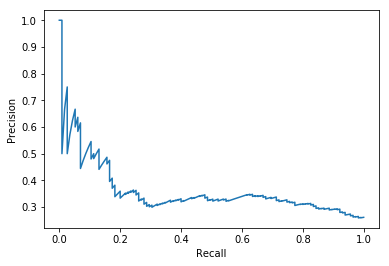

----------------------------------------------------
banjo :
              precision    recall  f1-score   support

         0.0       0.77      0.85      0.81       338
         1.0       0.52      0.39      0.45       140

   micro avg       0.72      0.72      0.72       478
   macro avg       0.65      0.62      0.63       478
weighted avg       0.70      0.72      0.70       478

----------------------------------------------------


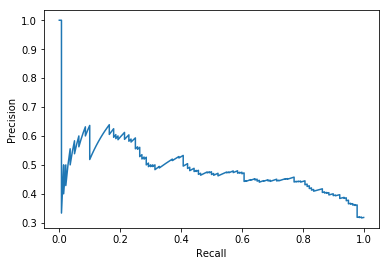

----------------------------------------------------
bass :
              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88       329
         1.0       0.79      0.51      0.62       134

   micro avg       0.82      0.82      0.82       463
   macro avg       0.81      0.73      0.75       463
weighted avg       0.82      0.82      0.80       463

----------------------------------------------------


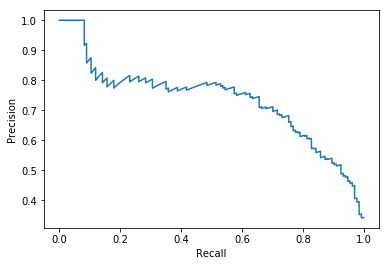

----------------------------------------------------
cello :
              precision    recall  f1-score   support

         0.0       0.75      0.76      0.76       259
         1.0       0.72      0.70      0.71       226

   micro avg       0.74      0.74      0.74       485
   macro avg       0.73      0.73      0.73       485
weighted avg       0.74      0.74      0.74       485

----------------------------------------------------


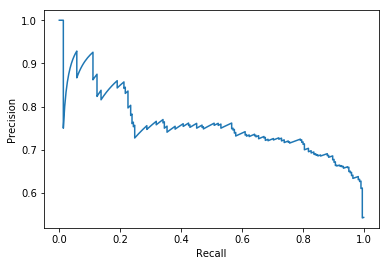

----------------------------------------------------
clarinet :
              precision    recall  f1-score   support

         0.0       0.79      0.99      0.88       503
         1.0       0.25      0.01      0.01       137

   micro avg       0.78      0.78      0.78       640
   macro avg       0.52      0.50      0.45       640
weighted avg       0.67      0.78      0.69       640

----------------------------------------------------


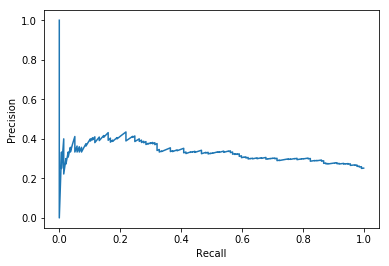

----------------------------------------------------
cymbals :
              precision    recall  f1-score   support

         0.0       0.88      0.81      0.84       139
         1.0       0.91      0.95      0.93       297

   micro avg       0.90      0.90      0.90       436
   macro avg       0.90      0.88      0.89       436
weighted avg       0.90      0.90      0.90       436

----------------------------------------------------


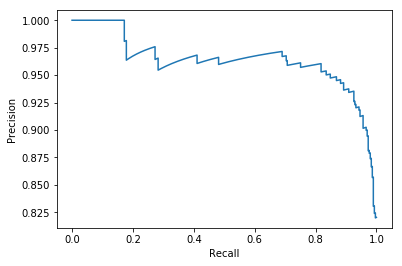

----------------------------------------------------
drums :
              precision    recall  f1-score   support

         0.0       0.91      0.75      0.82       146
         1.0       0.88      0.96      0.92       278

   micro avg       0.89      0.89      0.89       424
   macro avg       0.89      0.85      0.87       424
weighted avg       0.89      0.89      0.88       424

----------------------------------------------------


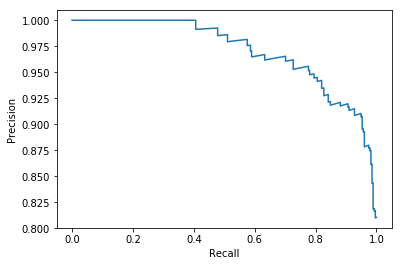

----------------------------------------------------
flute :
              precision    recall  f1-score   support

         0.0       0.72      0.88      0.79       387
         1.0       0.46      0.22      0.30       175

   micro avg       0.68      0.68      0.68       562
   macro avg       0.59      0.55      0.55       562
weighted avg       0.64      0.68      0.64       562

----------------------------------------------------


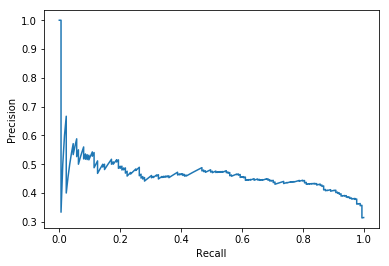

----------------------------------------------------
guitar :
              precision    recall  f1-score   support

         0.0       0.87      0.84      0.85       150
         1.0       0.92      0.93      0.93       286

   micro avg       0.90      0.90      0.90       436
   macro avg       0.89      0.89      0.89       436
weighted avg       0.90      0.90      0.90       436

----------------------------------------------------


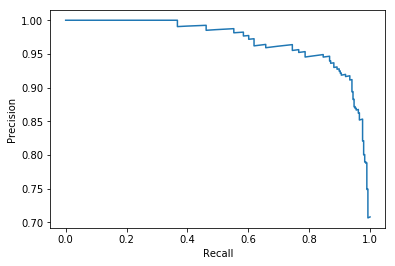

----------------------------------------------------
mallet_percussion :
              precision    recall  f1-score   support

         0.0       0.70      0.76      0.73       267
         1.0       0.66      0.59      0.62       211

   micro avg       0.68      0.68      0.68       478
   macro avg       0.68      0.67      0.68       478
weighted avg       0.68      0.68      0.68       478

----------------------------------------------------


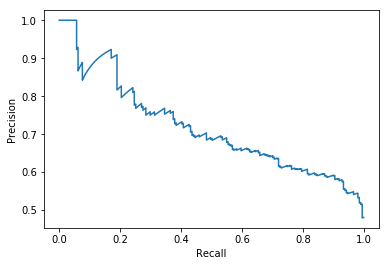

----------------------------------------------------
mandolin :
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80       434
         1.0       0.54      0.39      0.45       193

   micro avg       0.71      0.71      0.71       627
   macro avg       0.65      0.62      0.63       627
weighted avg       0.69      0.71      0.69       627

----------------------------------------------------


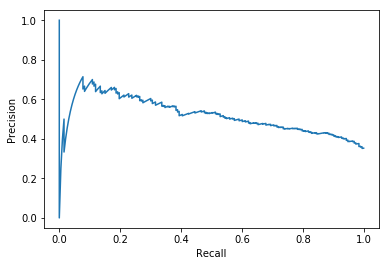

----------------------------------------------------
organ :
              precision    recall  f1-score   support

         0.0       0.78      0.92      0.84       310
         1.0       0.62      0.35      0.44       121

   micro avg       0.76      0.76      0.76       431
   macro avg       0.70      0.63      0.64       431
weighted avg       0.74      0.76      0.73       431

----------------------------------------------------


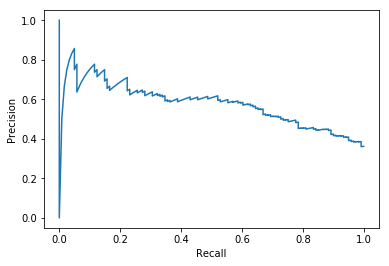

----------------------------------------------------
piano :
              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88       130
         1.0       0.93      0.97      0.95       285

   micro avg       0.93      0.93      0.93       415
   macro avg       0.93      0.90      0.91       415
weighted avg       0.93      0.93      0.93       415

----------------------------------------------------


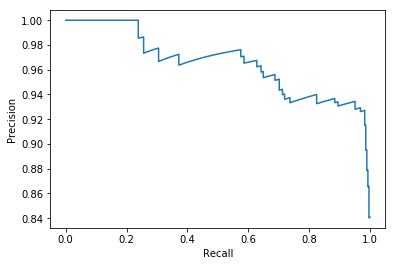

----------------------------------------------------
saxophone :
              precision    recall  f1-score   support

         0.0       0.76      0.69      0.72       324
         1.0       0.70      0.76      0.73       305

   micro avg       0.73      0.73      0.73       629
   macro avg       0.73      0.73      0.73       629
weighted avg       0.73      0.73      0.73       629

----------------------------------------------------


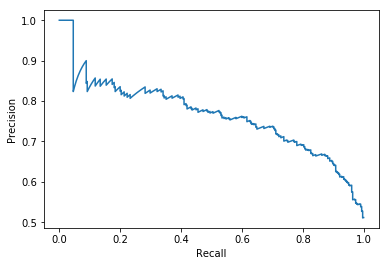

----------------------------------------------------
synthesizer :
              precision    recall  f1-score   support

         0.0       0.86      0.79      0.83       112
         1.0       0.92      0.95      0.93       268

   micro avg       0.90      0.90      0.90       380
   macro avg       0.89      0.87      0.88       380
weighted avg       0.90      0.90      0.90       380

----------------------------------------------------


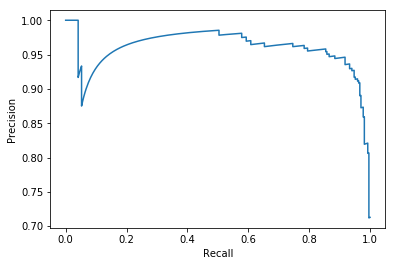

----------------------------------------------------
trombone :
              precision    recall  f1-score   support

         0.0       0.76      0.91      0.83       492
         1.0       0.67      0.38      0.49       228

   micro avg       0.75      0.75      0.75       720
   macro avg       0.72      0.65      0.66       720
weighted avg       0.73      0.75      0.72       720

----------------------------------------------------


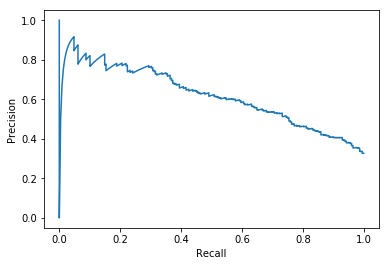

----------------------------------------------------
trumpet :
              precision    recall  f1-score   support

         0.0       0.73      0.83      0.78       467
         1.0       0.69      0.56      0.61       318

   micro avg       0.72      0.72      0.72       785
   macro avg       0.71      0.69      0.70       785
weighted avg       0.71      0.72      0.71       785

----------------------------------------------------


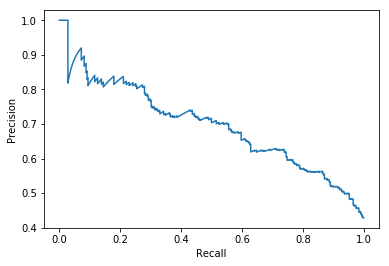

----------------------------------------------------
ukulele :
              precision    recall  f1-score   support

         0.0       0.80      0.90      0.85       408
         1.0       0.69      0.48      0.56       182

   micro avg       0.77      0.77      0.77       590
   macro avg       0.74      0.69      0.71       590
weighted avg       0.76      0.77      0.76       590

----------------------------------------------------


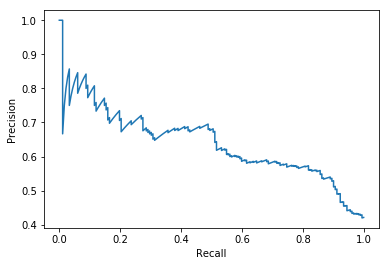

----------------------------------------------------
violin :
              precision    recall  f1-score   support

         0.0       0.78      0.65      0.71       237
         1.0       0.81      0.89      0.85       394

   micro avg       0.80      0.80      0.80       631
   macro avg       0.80      0.77      0.78       631
weighted avg       0.80      0.80      0.80       631

----------------------------------------------------


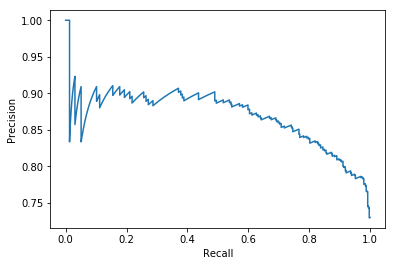

----------------------------------------------------
voice :
              precision    recall  f1-score   support

         0.0       0.87      0.77      0.82       150
         1.0       0.86      0.92      0.89       224

   micro avg       0.86      0.86      0.86       374
   macro avg       0.86      0.85      0.85       374
weighted avg       0.86      0.86      0.86       374

----------------------------------------------------


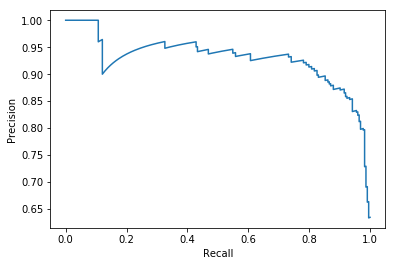

In [29]:
Test_dataset = ArrowOfTime(root_dir, sample_key[test_idx], Y_mask[test_idx], Y_true[test_idx])
Test_loader = torch.utils.data.DataLoader(dataset = Test_dataset, 
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                        collate_fn = my_collate)

wt = pickle.load(open('/scratch/rc3620/Capstone/Size_Exp_Random_Wt_NoLinear_Results.pkl','rb'))

model = snet2_jigsaw(20)
model.load_state_dict(wt['Full']['best_model_state_dict'])
model.to(device)

# Function for testing the model

print_results(Test_loader, model)

Micro Average of Accuracy:  74.30146360007603
----------------------------------------------------
accordion :
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88       423
         1.0       0.00      0.00      0.00       115

   micro avg       0.79      0.79      0.79       538
   macro avg       0.39      0.50      0.44       538
weighted avg       0.62      0.79      0.69       538

----------------------------------------------------


/home/rc3620/miniconda3/envs/localenv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


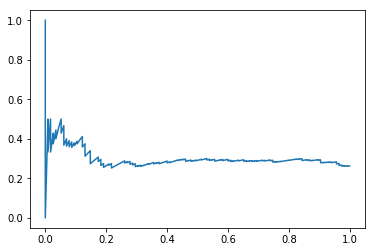

----------------------------------------------------
banjo :
              precision    recall  f1-score   support

         0.0       0.74      0.86      0.80       338
         1.0       0.45      0.26      0.33       140

   micro avg       0.69      0.69      0.69       478
   macro avg       0.59      0.56      0.56       478
weighted avg       0.65      0.69      0.66       478

----------------------------------------------------


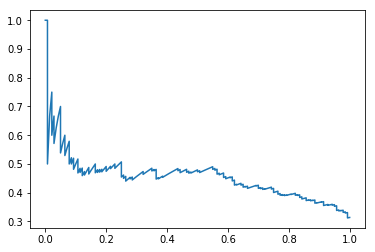

----------------------------------------------------
bass :
              precision    recall  f1-score   support

         0.0       0.76      0.94      0.84       329
         1.0       0.64      0.28      0.39       134

   micro avg       0.75      0.75      0.75       463
   macro avg       0.70      0.61      0.62       463
weighted avg       0.73      0.75      0.71       463

----------------------------------------------------


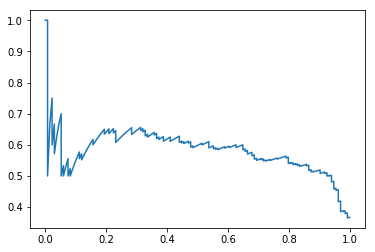

----------------------------------------------------
cello :
              precision    recall  f1-score   support

         0.0       0.81      0.72      0.76       259
         1.0       0.71      0.81      0.76       226

   micro avg       0.76      0.76      0.76       485
   macro avg       0.76      0.76      0.76       485
weighted avg       0.77      0.76      0.76       485

----------------------------------------------------


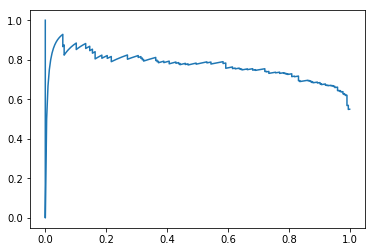

----------------------------------------------------
clarinet :
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88       503
         1.0       0.00      0.00      0.00       137

   micro avg       0.79      0.79      0.79       640
   macro avg       0.39      0.50      0.44       640
weighted avg       0.62      0.79      0.69       640

----------------------------------------------------


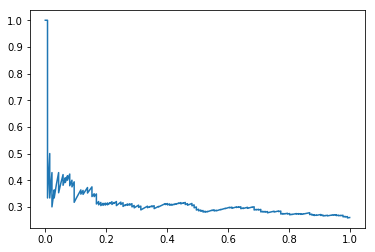

----------------------------------------------------
cymbals :
              precision    recall  f1-score   support

         0.0       0.85      0.78      0.82       139
         1.0       0.90      0.94      0.92       297

   micro avg       0.89      0.89      0.89       436
   macro avg       0.88      0.86      0.87       436
weighted avg       0.89      0.89      0.89       436

----------------------------------------------------


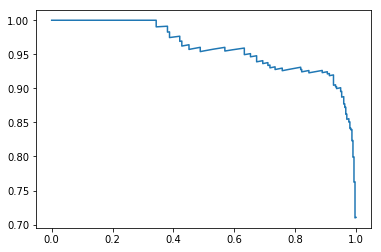

----------------------------------------------------
drums :
              precision    recall  f1-score   support

         0.0       0.95      0.68      0.80       146
         1.0       0.86      0.98      0.91       278

   micro avg       0.88      0.88      0.88       424
   macro avg       0.90      0.83      0.86       424
weighted avg       0.89      0.88      0.87       424

----------------------------------------------------


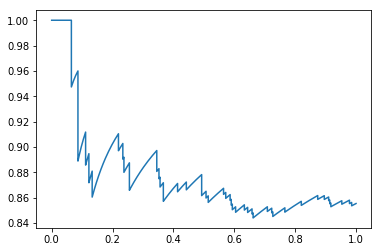

----------------------------------------------------
flute :
              precision    recall  f1-score   support

         0.0       0.72      0.90      0.80       387
         1.0       0.51      0.23      0.32       175

   micro avg       0.69      0.69      0.69       562
   macro avg       0.62      0.57      0.56       562
weighted avg       0.66      0.69      0.65       562

----------------------------------------------------


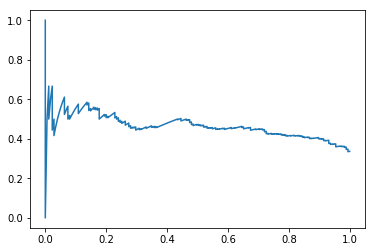

----------------------------------------------------
guitar :
              precision    recall  f1-score   support

         0.0       0.78      0.70      0.74       150
         1.0       0.85      0.90      0.87       286

   micro avg       0.83      0.83      0.83       436
   macro avg       0.82      0.80      0.81       436
weighted avg       0.83      0.83      0.83       436

----------------------------------------------------


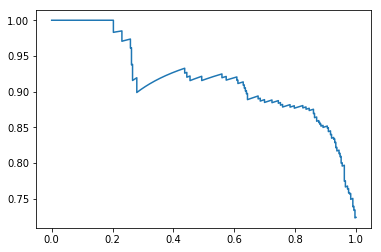

----------------------------------------------------
mallet_percussion :
              precision    recall  f1-score   support

         0.0       0.62      0.80      0.70       267
         1.0       0.61      0.39      0.48       211

   micro avg       0.62      0.62      0.62       478
   macro avg       0.62      0.60      0.59       478
weighted avg       0.62      0.62      0.60       478

----------------------------------------------------


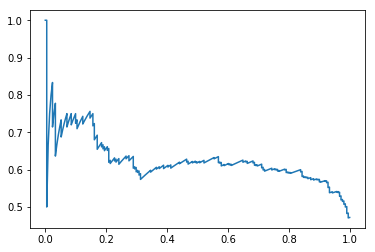

----------------------------------------------------
mandolin :
              precision    recall  f1-score   support

         0.0       0.72      0.90      0.80       434
         1.0       0.48      0.20      0.28       193

   micro avg       0.69      0.69      0.69       627
   macro avg       0.60      0.55      0.54       627
weighted avg       0.65      0.69      0.64       627

----------------------------------------------------


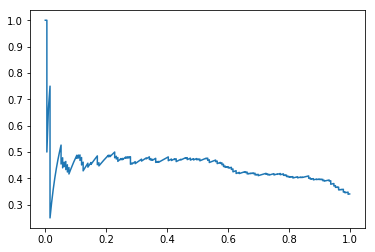

----------------------------------------------------
organ :
              precision    recall  f1-score   support

         0.0       0.78      0.92      0.85       310
         1.0       0.62      0.36      0.45       121

   micro avg       0.76      0.76      0.76       431
   macro avg       0.70      0.64      0.65       431
weighted avg       0.74      0.76      0.74       431

----------------------------------------------------


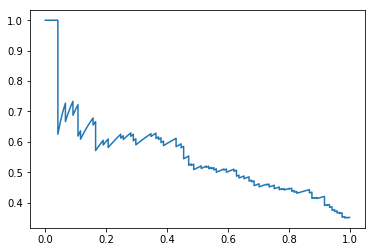

----------------------------------------------------
piano :
              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79       130
         1.0       0.90      0.91      0.91       285

   micro avg       0.87      0.87      0.87       415
   macro avg       0.85      0.85      0.85       415
weighted avg       0.87      0.87      0.87       415

----------------------------------------------------


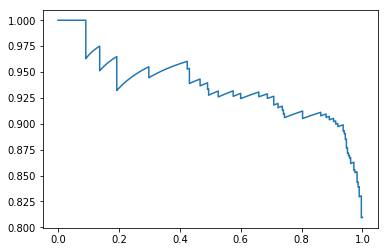

----------------------------------------------------
saxophone :
              precision    recall  f1-score   support

         0.0       0.64      0.61      0.63       324
         1.0       0.61      0.64      0.62       305

   micro avg       0.62      0.62      0.62       629
   macro avg       0.63      0.63      0.62       629
weighted avg       0.63      0.62      0.62       629

----------------------------------------------------


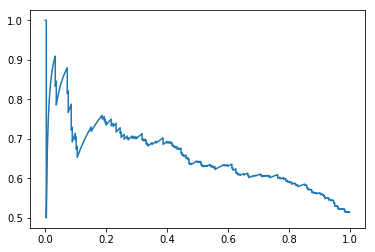

----------------------------------------------------
synthesizer :
              precision    recall  f1-score   support

         0.0       0.71      0.72      0.72       112
         1.0       0.88      0.88      0.88       268

   micro avg       0.83      0.83      0.83       380
   macro avg       0.80      0.80      0.80       380
weighted avg       0.83      0.83      0.83       380

----------------------------------------------------


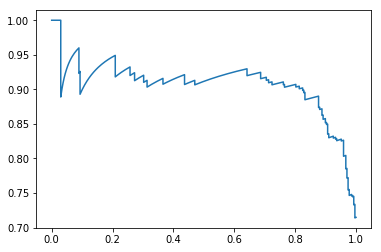

----------------------------------------------------
trombone :
              precision    recall  f1-score   support

         0.0       0.71      0.96      0.82       492
         1.0       0.65      0.14      0.24       228

   micro avg       0.70      0.70      0.70       720
   macro avg       0.68      0.55      0.53       720
weighted avg       0.69      0.70      0.63       720

----------------------------------------------------


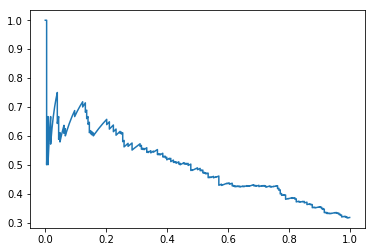

----------------------------------------------------
trumpet :
              precision    recall  f1-score   support

         0.0       0.69      0.77      0.72       467
         1.0       0.59      0.48      0.53       318

   micro avg       0.65      0.65      0.65       785
   macro avg       0.64      0.62      0.63       785
weighted avg       0.65      0.65      0.65       785

----------------------------------------------------


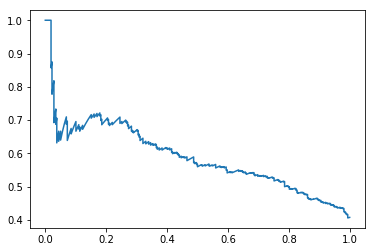

----------------------------------------------------
ukulele :
              precision    recall  f1-score   support

         0.0       0.69      0.99      0.82       408
         1.0       0.57      0.02      0.04       182

   micro avg       0.69      0.69      0.69       590
   macro avg       0.63      0.51      0.43       590
weighted avg       0.66      0.69      0.58       590

----------------------------------------------------


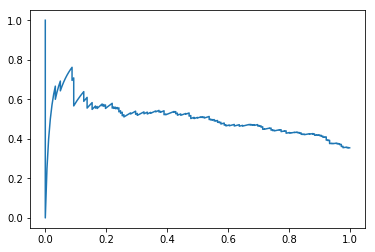

----------------------------------------------------
violin :
              precision    recall  f1-score   support

         0.0       0.73      0.62      0.67       237
         1.0       0.79      0.86      0.82       394

   micro avg       0.77      0.77      0.77       631
   macro avg       0.76      0.74      0.74       631
weighted avg       0.77      0.77      0.76       631

----------------------------------------------------


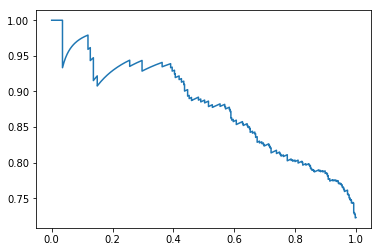

----------------------------------------------------
voice :
              precision    recall  f1-score   support

         0.0       0.81      0.65      0.72       150
         1.0       0.79      0.90      0.84       224

   micro avg       0.80      0.80      0.80       374
   macro avg       0.80      0.78      0.78       374
weighted avg       0.80      0.80      0.79       374

----------------------------------------------------


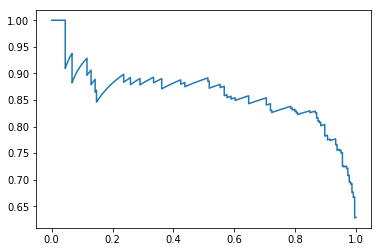

In [27]:
Test_dataset = ArrowOfTime(root_dir, sample_key[test_idx], Y_mask[test_idx], Y_true[test_idx])
Test_loader = torch.utils.data.DataLoader(dataset = Test_dataset, 
                                              batch_size = BATCH_SIZE,
                                              shuffle = False,
                                        collate_fn = my_collate)
wt = pickle.load(open('/scratch/rc3620/Capstone/Size_Exp_Flip_Wt_Results.pkl','rb'))

model = snet2_jigsaw(20)
model.load_state_dict(wt[500]['best_model_state_dict'])
model.to(device)

print_results(Test_loader, model)

Micro Average of Accuracy:  75.40391560539821
----------------------------------------------------
accordion :
              precision    recall  f1-score   support

         0.0       0.79      0.93      0.86       423
         1.0       0.29      0.10      0.15       115

   micro avg       0.75      0.75      0.75       538
   macro avg       0.54      0.52      0.50       538
weighted avg       0.68      0.75      0.71       538

----------------------------------------------------


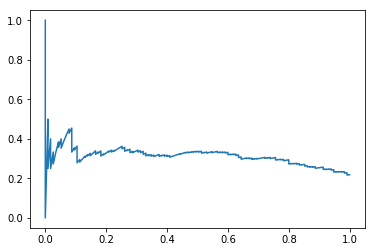

----------------------------------------------------
banjo :
              precision    recall  f1-score   support

         0.0       0.77      0.85      0.81       338
         1.0       0.51      0.39      0.44       140

   micro avg       0.71      0.71      0.71       478
   macro avg       0.64      0.62      0.62       478
weighted avg       0.69      0.71      0.70       478

----------------------------------------------------


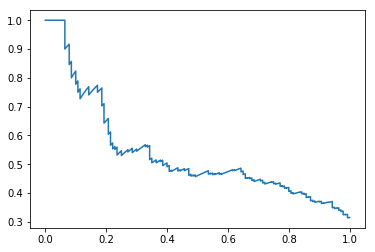

----------------------------------------------------
bass :
              precision    recall  f1-score   support

         0.0       0.82      0.91      0.87       329
         1.0       0.71      0.52      0.60       134

   micro avg       0.80      0.80      0.80       463
   macro avg       0.77      0.72      0.73       463
weighted avg       0.79      0.80      0.79       463

----------------------------------------------------


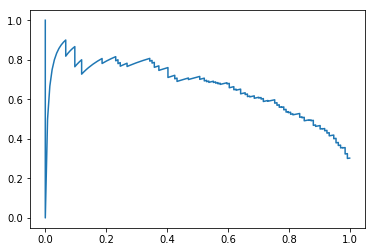

----------------------------------------------------
cello :
              precision    recall  f1-score   support

         0.0       0.71      0.81      0.76       259
         1.0       0.74      0.62      0.67       226

   micro avg       0.72      0.72      0.72       485
   macro avg       0.73      0.71      0.72       485
weighted avg       0.72      0.72      0.72       485

----------------------------------------------------


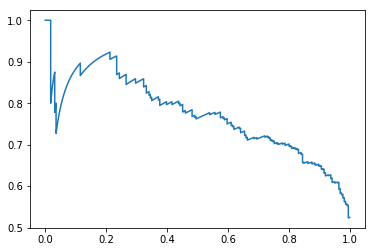

----------------------------------------------------
clarinet :
              precision    recall  f1-score   support

         0.0       0.80      0.95      0.87       503
         1.0       0.38      0.10      0.16       137

   micro avg       0.77      0.77      0.77       640
   macro avg       0.59      0.53      0.51       640
weighted avg       0.71      0.77      0.72       640

----------------------------------------------------


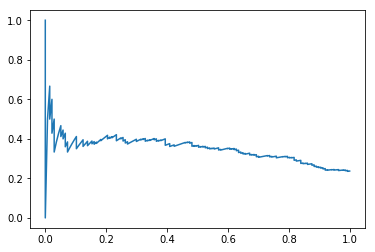

----------------------------------------------------
cymbals :
              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81       139
         1.0       0.90      0.93      0.91       297

   micro avg       0.88      0.88      0.88       436
   macro avg       0.87      0.85      0.86       436
weighted avg       0.88      0.88      0.88       436

----------------------------------------------------


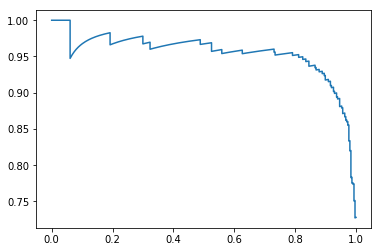

----------------------------------------------------
drums :
              precision    recall  f1-score   support

         0.0       0.95      0.68      0.80       146
         1.0       0.86      0.98      0.91       278

   micro avg       0.88      0.88      0.88       424
   macro avg       0.90      0.83      0.86       424
weighted avg       0.89      0.88      0.87       424

----------------------------------------------------


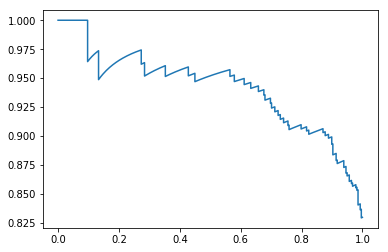

----------------------------------------------------
flute :
              precision    recall  f1-score   support

         0.0       0.76      0.83      0.79       387
         1.0       0.52      0.41      0.46       175

   micro avg       0.70      0.70      0.70       562
   macro avg       0.64      0.62      0.62       562
weighted avg       0.68      0.70      0.69       562

----------------------------------------------------


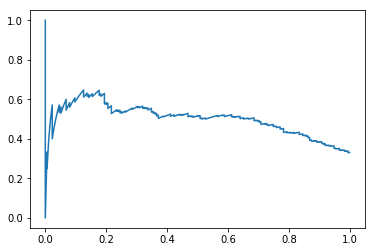

----------------------------------------------------
guitar :
              precision    recall  f1-score   support

         0.0       0.80      0.70      0.75       150
         1.0       0.85      0.91      0.88       286

   micro avg       0.84      0.84      0.84       436
   macro avg       0.83      0.80      0.81       436
weighted avg       0.83      0.84      0.83       436

----------------------------------------------------


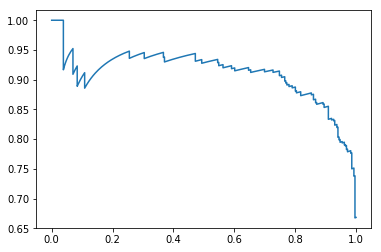

----------------------------------------------------
mallet_percussion :
              precision    recall  f1-score   support

         0.0       0.65      0.73      0.69       267
         1.0       0.60      0.50      0.54       211

   micro avg       0.63      0.63      0.63       478
   macro avg       0.62      0.62      0.62       478
weighted avg       0.63      0.63      0.62       478

----------------------------------------------------


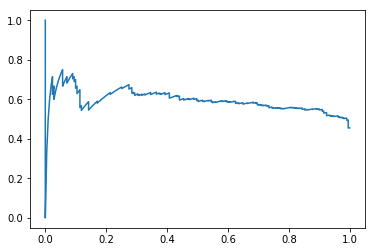

----------------------------------------------------
mandolin :
              precision    recall  f1-score   support

         0.0       0.76      0.83      0.79       434
         1.0       0.52      0.41      0.46       193

   micro avg       0.70      0.70      0.70       627
   macro avg       0.64      0.62      0.63       627
weighted avg       0.69      0.70      0.69       627

----------------------------------------------------


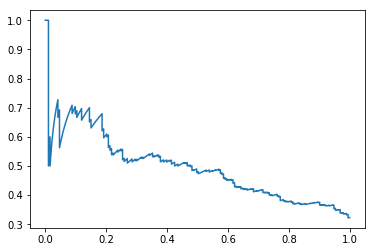

----------------------------------------------------
organ :
              precision    recall  f1-score   support

         0.0       0.79      0.89      0.84       310
         1.0       0.58      0.38      0.46       121

   micro avg       0.75      0.75      0.75       431
   macro avg       0.68      0.64      0.65       431
weighted avg       0.73      0.75      0.73       431

----------------------------------------------------


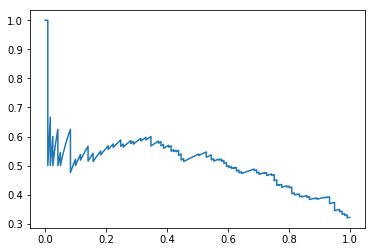

----------------------------------------------------
piano :
              precision    recall  f1-score   support

         0.0       0.87      0.79      0.83       130
         1.0       0.91      0.94      0.93       285

   micro avg       0.90      0.90      0.90       415
   macro avg       0.89      0.87      0.88       415
weighted avg       0.90      0.90      0.90       415

----------------------------------------------------


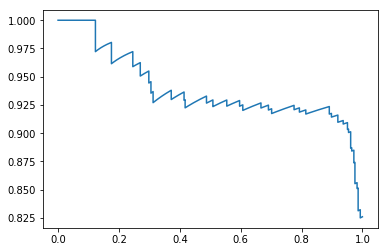

----------------------------------------------------
saxophone :
              precision    recall  f1-score   support

         0.0       0.69      0.68      0.68       324
         1.0       0.66      0.68      0.67       305

   micro avg       0.68      0.68      0.68       629
   macro avg       0.68      0.68      0.68       629
weighted avg       0.68      0.68      0.68       629

----------------------------------------------------


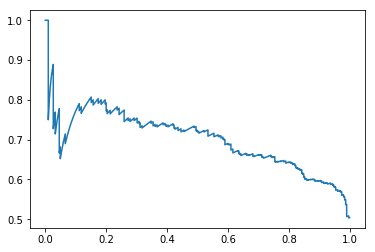

----------------------------------------------------
synthesizer :
              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76       112
         1.0       0.90      0.91      0.90       268

   micro avg       0.86      0.86      0.86       380
   macro avg       0.83      0.83      0.83       380
weighted avg       0.86      0.86      0.86       380

----------------------------------------------------


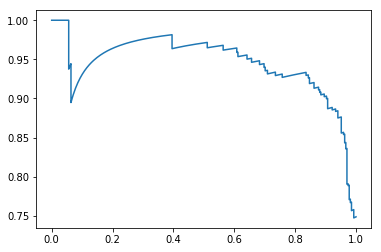

----------------------------------------------------
trombone :
              precision    recall  f1-score   support

         0.0       0.75      0.88      0.81       492
         1.0       0.59      0.38      0.46       228

   micro avg       0.72      0.72      0.72       720
   macro avg       0.67      0.63      0.64       720
weighted avg       0.70      0.72      0.70       720

----------------------------------------------------


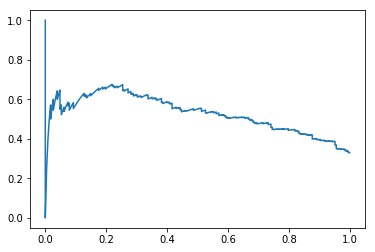

----------------------------------------------------
trumpet :
              precision    recall  f1-score   support

         0.0       0.72      0.77      0.75       467
         1.0       0.63      0.57      0.60       318

   micro avg       0.69      0.69      0.69       785
   macro avg       0.68      0.67      0.67       785
weighted avg       0.68      0.69      0.68       785

----------------------------------------------------


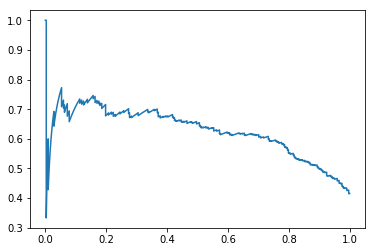

----------------------------------------------------
ukulele :
              precision    recall  f1-score   support

         0.0       0.76      0.84      0.80       408
         1.0       0.53      0.39      0.45       182

   micro avg       0.70      0.70      0.70       590
   macro avg       0.64      0.62      0.62       590
weighted avg       0.69      0.70      0.69       590

----------------------------------------------------


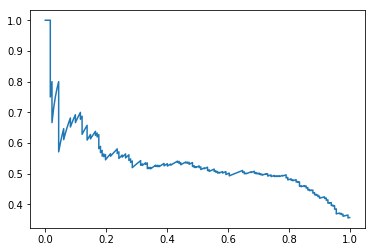

----------------------------------------------------
violin :
              precision    recall  f1-score   support

         0.0       0.76      0.64      0.70       237
         1.0       0.80      0.88      0.84       394

   micro avg       0.79      0.79      0.79       631
   macro avg       0.78      0.76      0.77       631
weighted avg       0.79      0.79      0.79       631

----------------------------------------------------


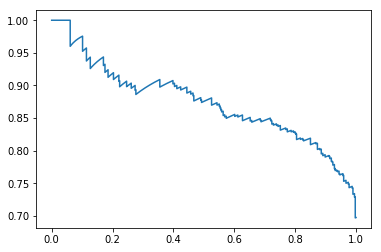

----------------------------------------------------
voice :
              precision    recall  f1-score   support

         0.0       0.80      0.65      0.72       150
         1.0       0.79      0.89      0.84       224

   micro avg       0.80      0.80      0.80       374
   macro avg       0.80      0.77      0.78       374
weighted avg       0.80      0.80      0.79       374

----------------------------------------------------


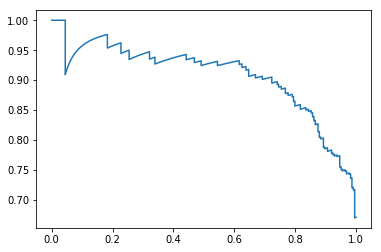

In [23]:
Test_dataset = ArrowOfTime(root_dir, sample_key[test_idx], Y_mask[test_idx], Y_true[test_idx])
Test_loader = torch.utils.data.DataLoader(dataset = Test_dataset, 
                                              batch_size = BATCH_SIZE,
                                              shuffle = False,
                                        collate_fn = my_collate)
wt = pickle.load(open('/scratch/rc3620/Capstone/Size_Exp_resnet_Jigsaw_Wt_Results.pkl','rb'))
model = models.resnet18(num_classes=20)
model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
model = model.to(device)
model.load_state_dict(wt['Full']['best_model_state_dict'])
model.to(device)
print_results(Test_loader, model)

In [5]:
Acc = [rand_nolin_acc[-1], jigsaw_nolin_acc[-1], flip_nolin_acc[-1], rand_resnet_acc[-1], jigsaw_resnet_acc[-1], \
      rand_lin_acc[-1], jigsaw_lin_acc[-1], jigsaw_1s_nolin_acc[-1], jigsaw_1s_lin_acc[-1]]

In [6]:
Acc

[78.06500665272762,
 71.93499334727238,
 73.46512069948679,
 74.29195970347843,
 75.40391560539821,
 74.33947918646645,
 74.36799087625927,
 72.69530507508078,
 73.89279604637902]